# Installing necessary packages

In [2]:
!pip install tensorflow numpy matplotlib seaborn scikit-learn pillow graphviz pydot pandas
!pip install opencv-python-headless
!pip install mlxtend  
!pip install lime shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 85.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 92.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 82.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 81.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 68.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 83.2 MB/s eta 0:00:00

# Importing libraries

In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
import shap
import lime
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from mlxtend.plotting import plot_confusion_matrix
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [56]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow logs
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Data Loading and Preprocessing

### Data Augmentation
### Normalization
### Image Data Generators 
### Loading and Preparing the data as per the labels

In [57]:

# Data directories
train_dir = 'Dissertation/chest_xray/train/'
test_dir = 'Dissertation/chest_xray/test/'

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=False)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)


# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Class Weights Balancing

In [58]:

# Compute class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', 
                                     classes=np.unique(train_generator.classes), 
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))
print(f'Computed class weights: {class_weights}')


Computed class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


# Model Building Process

### Defining Input Shape and Layer
### Building Model Layer for the Stacked Model
### Creating output segment for both models
### Compiling the model as per the optimizer , categorical cross_entrophy and accuracy metric
### Defining necessary callbacks for model optimization during training

In [59]:
# Define input layer
input_shape = (224, 224, 3)
input_layer = Input(shape=input_shape)

# Build MobileNet model
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_mobilenet.layers:
    layer.trainable = False
model_mobilenet = base_mobilenet(input_layer)
model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
output_mobilenet = Flatten()(model_mobilenet)

# Build DenseNet model
base_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in base_densenet.layers:
    layer.trainable = False
model_densenet = base_densenet(input_layer)
model_densenet = GlobalAveragePooling2D()(model_densenet)
output_densenet = Flatten()(model_densenet)

# Merge outputs of both models
merged = Concatenate()([output_mobilenet, output_densenet])

# Add dense layers
x = BatchNormalization()(merged)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the final model
stacked_model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
opt = Adam(learning_rate=0.0001)
stacked_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
stacked_model.summary()

# Callbacks
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint('stacked_model_best_weights.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_1.00_224  │ (None, 7, 7,      │  3,228,864 │ input_layer_18[0… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ densenet121         │ (None, 7, 7,      │  7,037,504 │ input_layer_18[0… │
│ (Functional)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ mobilenet_1.00_2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1024)      │          0 │ densenet121[0][0] │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 1024)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 1024)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 2048)      │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ concatenate_6[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dropout_8[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 128)       │     32,896 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 128)       │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 2)         │        258 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,833,282 (41.33 MB)

 Trainable params: 562,306 (2.15 MB)

 Non-trainable params: 10,270,976 (39.18 MB)

# Training the Stacked Model

In [60]:
# Train the model
history = stacked_model.fit(
    train_generator,
    validation_data=validation_generator,
    callbacks=[lr_reduce, checkpoint, early_stopping],
    class_weight=class_weights,
    epochs=5
)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 393ms/step - accuracy: 0.6742 - loss: 0.6482 - val_accuracy: 0.8798 - val_loss: 0.3145 - learning_rate: 1.0000e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 332ms/step - accuracy: 0.8839 - loss: 0.2498 - val_accuracy: 0.8990 - val_loss: 0.2651 - learning_rate: 1.0000e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 335ms/step - accuracy: 0.9206 - loss: 0.1913 - val_accuracy: 0.9006 - val_loss: 0.2550 - learning_rate: 1.0000e-04
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 54s 319ms/step - accuracy: 0.9380 - loss: 0.1527 - val_accuracy: 0.9022 - val_loss: 0.2600 - learning_rate: 1.0000e-04
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 336ms/step - accuracy: 0.9408 - loss: 0.1446 - val_accuracy: 0.9087 - val_loss: 0.2521 - learning_rate: 1.0000e-04


# Model Evaluation and Performance
### Checking model performance through Training and Validation Accuracy/Loss

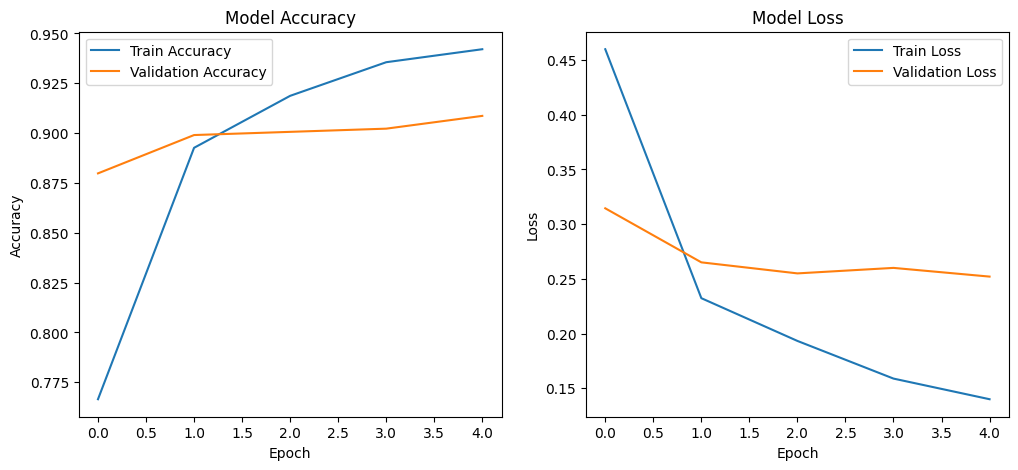

In [69]:

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Loading the best model with saved weights and Predicting on the test set

In [62]:
# Load the best model from the saved weights
best_model = tf.keras.models.load_model('stacked_model_best_weights.keras')

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(validation_generator)
print(f'Test accuracy: {test_acc * 100:.2f}%')

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - accuracy: 0.8734 - loss: 0.3505
Test accuracy: 90.87%


### Classification Report and Confusion matrix based on the prediction from the model on test dataset

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


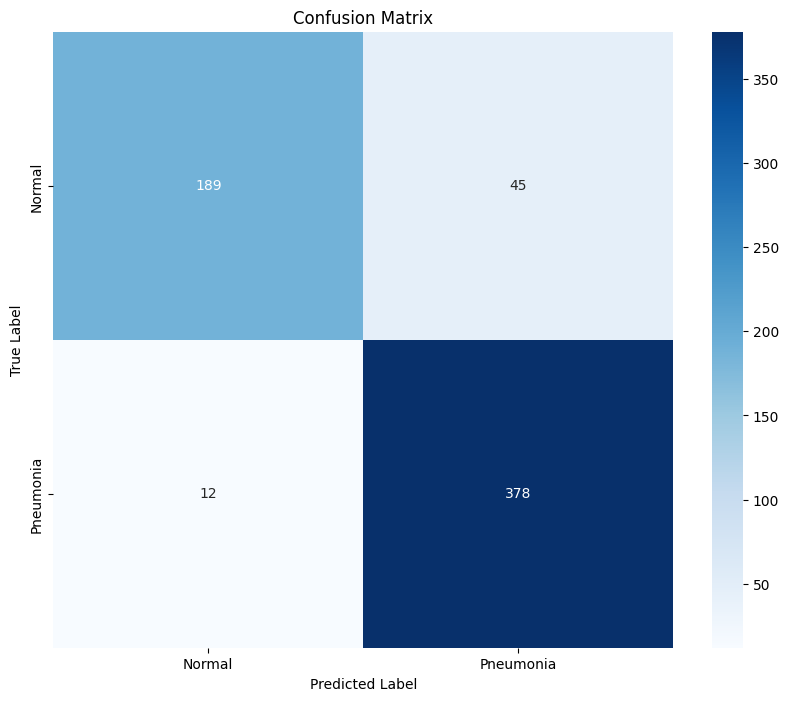

              precision    recall  f1-score   support

      Normal       0.94      0.81      0.87       234
   Pneumonia       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [70]:
# Test data loading
test_path = Path(test_dir)
normal_cases_dir = test_path / 'NORMAL'
pneumonia_cases_dir = test_path / 'PNEUMONIA'

# Creating a DataFrame of test data
normal_cases = list(normal_cases_dir.glob('*.jpeg'))
pneumonia_cases = list(pneumonia_cases_dir.glob('*.jpeg'))

test_data = [(img, 0) for img in normal_cases] + [(img, 1) for img in pneumonia_cases]
test_data = pd.DataFrame(test_data, columns=['image', 'label']).sample(frac=1.).reset_index(drop=True)

# Preprocessing function for test images
def preprocess_test_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x_img = image.img_to_array(img)
    x_img = np.expand_dims(x_img, axis=0)
    return preprocess_input(x_img)

# Prepare test data for prediction
x_test = np.zeros((len(test_data), 224, 224, 3))
for i, img_path in enumerate(test_data['image']):
    x_test[i] = preprocess_test_image(str(img_path))

y_test_true = np.asarray(test_data['label'])

# Generate predictions (probabilities)
y_test_pred_prob = stacked_model.predict(x_test)

# Convert probabilities to class labels
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.yticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.show()

# Classification report
print(classification_report(y_test_true, y_test_pred, target_names=['Normal', 'Pneumonia']))



### ROC-AUC for the Positive/Negative rates based on probabilities

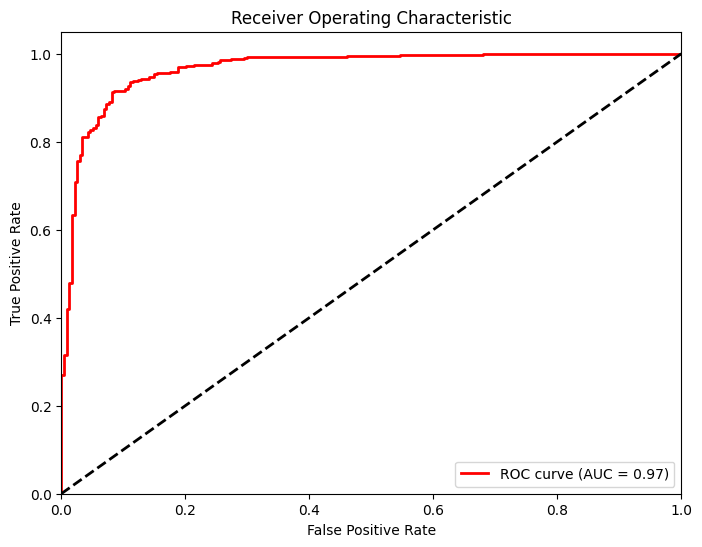

In [66]:
# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test_true, y_test_pred_prob[:, 1])  # Use probabilities for the positive class
roc_auc = roc_auc_score(y_test_true, y_test_pred_prob[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Implementing XAI

# 1. Grad-CAM

### Generating a Grad-CAM heatmap for a given image and convolutional layer within the submodel.
#### we take Preprocessed input image, convolutional layer inside the submodel, target label (class index), specific submodel (MobileNet or DenseNet) for specification and generate a heatmap showing the regions important for the prediction.

In [98]:
def xray_CAM_for_submodel(x_img, conv_layer_name, label, submodel):
    
    # Extracting the convolutional layer inside the specified submodel
    conv_layer = submodel.get_layer(conv_layer_name)

    # new model that outputs the conv layer and final output of the submodel
    grad_model = tf.keras.models.Model([submodel.input], [conv_layer.output, submodel.output])

    # GradientTape to record operations
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(x_img)

        # checking shape of the predictions
        predictions = predictions[0]  # Extracting batch element (batch size = 1)
        if len(predictions.shape) == 1:  # using label as index
            loss = predictions[label]
        else:
            loss = predictions[:, label]  # using batch indexing

    # Calculating the gradient of the loss in reference to the conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Pooling the gradients over all the axes
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighing the output feature map with the pooled gradients
    conv_outputs = conv_outputs[0]  # initial batch element
    pooled_grads = pooled_grads.numpy()
    conv_outputs = conv_outputs.numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    # Generating the heatmap
    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  # Normalizing the heatmap
    
    return heatmap


In [99]:
from tensorflow.keras.applications.mobilenet import preprocess_input

def preprocess_test_image(img_path):
    """ Preprocess image for MobileNet or DenseNet """
    img = image.load_img(img_path, target_size=(224, 224))
    x_img = image.img_to_array(img)
    x_img = np.expand_dims(x_img, axis=0)  # Add batch dimension
    x_img = preprocess_input(x_img)  # Preprocessing for the network
    return x_img


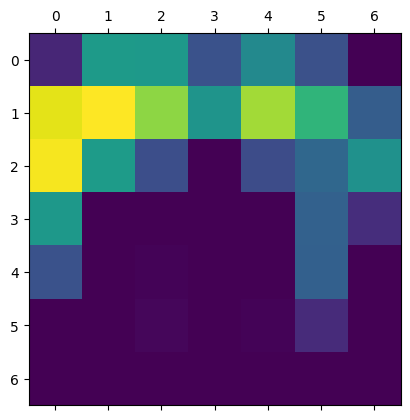

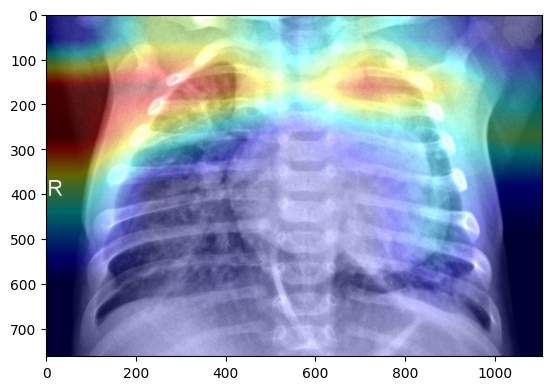

In [100]:
img_path = 'Dissertation/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
x_img = preprocess_test_image(img_path)

# Getting the MobileNet submodel
mobilenet_model = best_model.get_layer('mobilenet_1.00_224')

# Using the last convolutional layer of MobileNet for Grad-CAM
heatmap = xray_CAM_for_submodel(x_img, 'conv_pw_13', 1, mobilenet_model)

# Plotting the heatmap
plt.matshow(heatmap)
plt.show()

# Showing the Grad-CAM heatmap superimposed on the X-ray image
show_on_xray(img_path, heatmap)


# 2. LIME

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━

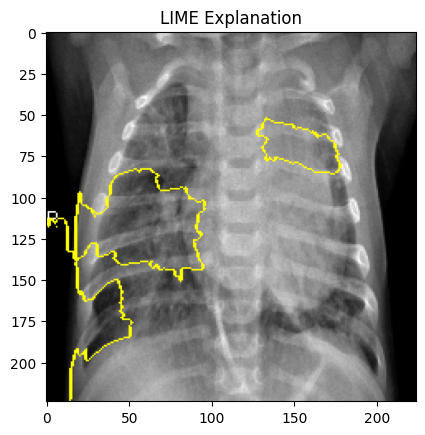

In [71]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Loading and preprocessing a test image for LIME explanation
img_path = 'Dissertation/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array_expanded = np.expand_dims(img_array, axis=0)
img_array_preprocessed = preprocess_input(img_array_expanded)

# Predicting the image using the model
pred = best_model.predict(img_array_preprocessed)
print(f'Predicted class: {np.argmax(pred)}')

# LIME Explanation
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_array.astype('double'),  
                                         best_model.predict,
                                         top_labels=2,
                                         hide_color=0,
                                         num_samples=1000)

# Visualizing LIME explanation
temp, mask = explanation.get_image_and_mask(np.argmax(pred), positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title("LIME Explanation")
plt.show()


# 3. Saliency Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


W0000 00:00:1725617731.495844     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.518346     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.518617     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.518892     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.519104     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.519335     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.519653     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.519936     296 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1725617731.520163     296 gp

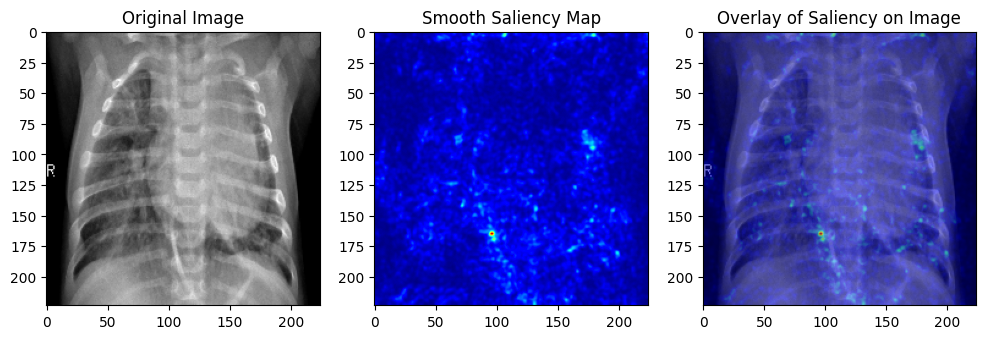

In [72]:
def generate_smoothgrad_saliency_map(img_path, model, num_samples=100, noise_level=0.1):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    predictions = model.predict(x)
    predicted_class = np.argmax(predictions)

    smooth_grad = np.zeros_like(x)

    for i in range(num_samples):
        noisy_img = x + noise_level * np.random.normal(size=x.shape)
        noisy_img = np.clip(noisy_img, -1, 1)
        
        with tf.GradientTape() as tape:
            input_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
            tape.watch(input_img)
            preds = model(input_img)
            loss = preds[:, predicted_class]

        grads = tape.gradient(loss, input_img)
        smooth_grad += grads.numpy()

    smooth_grad /= num_samples

    saliency = np.max(np.abs(smooth_grad), axis=-1)[0]
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-10)
    saliency = np.power(saliency, 1.5)
    saliency = cv2.GaussianBlur(saliency, (5, 5), 0)

    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    img_gray = cv2.resize(img_gray, (224, 224))

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(saliency, cmap='jet')
    plt.title('Smooth Saliency Map')

    plt.subplot(1, 3, 3)
    plt.imshow(img_gray, cmap='gray')
    plt.imshow(saliency, cmap='jet', alpha=0.5)
    plt.title('Overlay of Saliency on Image')

    plt.show()

# Generating smooth saliency map for a test image
test_img_path = 'Dissertation/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
generate_smoothgrad_saliency_map(test_img_path, best_model)
